In [1]:
## based on Matlab code from Mike
# runs an FFT on ONE radar depth plot at a time

In [1]:
#Import packages
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft
import scipy.optimize
import pandas as pd
import statsmodels.api as sm
from fft_radarfuncs import *
from lmfit.models import SkewedGaussianModel


In [2]:
# Function to calculate the exponential with constants a and b
def func(x, a, b,c):
    return a/(b*(c+x))

2281.9164877305
2390.0
2275.5778308201375
360


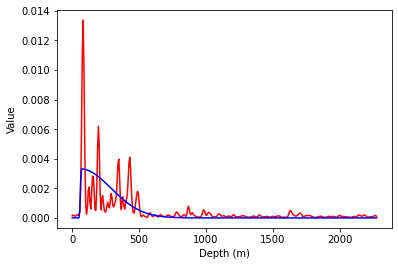

In [27]:
#Import csv files
csv_list = 'S_00325703_5full.csv','S_00429802_1full.csv', 'S_00429802_4full.csv',
'S_00325703_6full.csv','S_00429802_2full.csv','S_00325703_7full.csv','S_00429802_3full.csv'

column_names = ['depth', 'value']
csv = pd.read_csv(csv_list[0], names=column_names, skiprows=2)
#print(csv)

x = csv.depth.to_list()
y = csv.value.to_list()

x_zoom = x[2390:2750]
y_zoom = y[2390:2750]
x_zoom = np.array(x_zoom)
x_zoom = x_zoom.astype(np.float)

c = 300000000
pix_t = .0000000375
er = 0.56343616981 # 1/sqrt(3.15) (dielectric = 3.15 for water ice)
    
depthh = c*pix_t*er*len(x_zoom) 
print(depthh)
print(x_zoom[0])    
x_m = (x_zoom-x_zoom[0])*c*pix_t*er
print(x_m[-1])
print(len(x_m))
#pars, cov = scipy.optimize.curve_fit(f=func, xdata=x_zoom, ydata=y_zoom, p0=[.07, 1,-min(x_zoom)])
#print(pars)
# Skewed Gaussian fit
model = SkewedGaussianModel()
params = model.make_params(amplitude=(max(y_zoom)), center=min(x_zoom)+20, sigma=20, gamma=.05)
result = model.fit(y_zoom, params, x=x_zoom)
fit = result.best_fit+np.mean(y_zoom[-150:])
#print(np.mean(y_zoom[-150:]))
#print(fit)
# x_zoom = x[2380:2480]
# y_zoom = y[2380:2480]

plt.plot(x_m, y_zoom, 'r')
#plt.plot(x_zoom, func(x_zoom, *pars), linestyle='--', color='black')
plt.plot(x_m, result.best_fit, color = 'b')
#plt.plot(x, y, 'r')
plt.ylabel('Value')
plt.xlabel('Depth (m)')
plt.show()

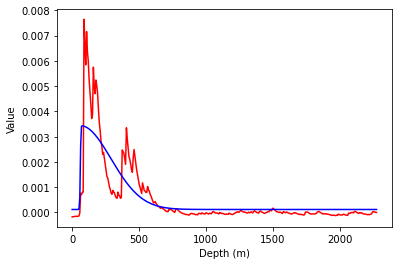

0.0005257916085560687
0.0005257916085560687
1.7227789726151687e-06
1.7227789726151687e-06


In [29]:
### AR1 
#same length and lag-1 autocorr as y
## might need to fit to a decay slope
x=x_m
y=y_zoom


# def ar1(x,y,fit):
#     ### produces an AR1 (markov) time series with the same length and lag-1
#     ### autocorrelation as y
#     ### returns m, the AR1 time series

    
#     lag1 = sm.tsa.acf(y, nlags=1,fft=True)[1]
    
#     mu = np.mean(y)

#     sigma = np.std(y)

#     errors = np.random.randn(len(y))
#     errors = np.square(errors) # negative values don't make sense
#     errors = errors * fit
    
#     m = [0]*len(y)

#     for i in range(1,len(m)):
#         m[i]=lag1*m[i-1]+errors[i]
    
#     #make variance(m)=variance(y) and mean(m)=mean(y)
#     m = mu + (m - np.mean(m))*(sigma/np.std(m))
    
#     return m

##compute line to fit synthetic data to
# Skewed Gaussian fit
model = SkewedGaussianModel()
params = model.make_params(amplitude=(max(y)), center=min(x)+20, sigma=20, gamma=1)
result = model.fit(y, params, x=x)
fit = result.best_fit+np.mean(y[-150:]) # prevents fit from damping out all of the noise on right-handed side


m=ar1(x,y,fit)
plt.plot(x, m, 'r')
plt.plot(x,fit,'b')
plt.ylabel('Value')
plt.xlabel('Depth (m)')
plt.show()

print(np.mean(y))
print(np.mean(m))
print(np.var(y))
print(np.var(m))

2275.5778308201375


<ipython-input-26-41beed72409f>:51: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(1/f, P1)


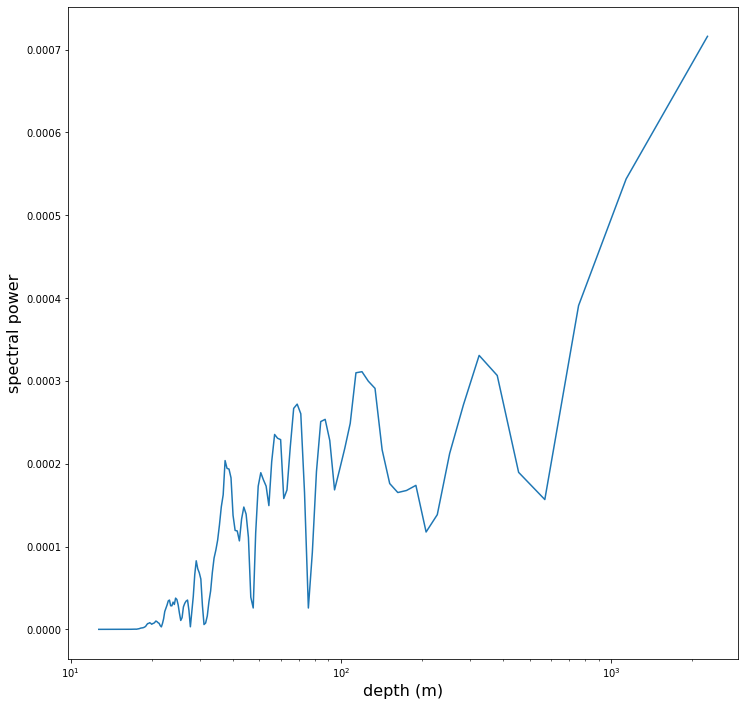

In [26]:
#run fft 
#adapted from Mike Sori's matlab code
#mike's X = the Nx1 matrix of values = my Y
#mike's depth = int, total topographic relief = size of my pixel range converted to seconds
X = x_m
Y = y_zoom

#depth and values must be the same length, and length must be an even number
if len(X) != len(Y):
    raise Exception("depth and values must be the same length")     
if len(X) % 2 != 0:
    X.pop()
    Y.pop()


#SHARAD radargrams are 3.75e-8 seconds per pixel
deptht = .0000000375*len(X)

# #convert from pixels to meters
# c = 300000000
# pix_t = .0000000375
# er = 0.56343616981 # 1/sqrt(3.15) (dielectric = 3.15 for water ice)
    
# depthh = c*pix_t*er*len(x_zoom) 
# #print(depthh)
# #print(x_zoom[0])    
# x_m = (x_zoom-x_zoom[0])*c*pix_t*er
# #print(x_m[-1])

# X = x_m

#Fs = len(Y)/deptht #sampling rate (s).

Fs = len(Y)/(X[-1]-X[0]) #sampling rate (m).
T = 1/Fs
L = len(X)
t = np.arange(L)*T 

#take fft, compute the two-sided spectrum P2. 
#Then compute the single-sided spectrum P1 based on P2 and the even-valued signal length L
ffty = fft(Y)
P2 = np.abs(ffty/L)
P1 = P2[0:np.int(np.floor(L/2))]
P1[1:len(P1)-1]=2*P1[1:len(P1)-1]

#frequency
f = Fs*np.arange(0,(L/2))/L

#plot in wavelength space
plt.figure(figsize = (12, 12))
plt.plot(1/f, P1)
plt.xscale('log')
plt.xlabel('depth (m)', fontsize=16)
plt.ylabel('spectral power', fontsize=16) #units are whatever JMARS reports, I have to look into this
plt.show()